## Cross-sectional Factor Analysis of Portfolio Returns

In this notebook, we use the Pipeline API in Quantopian to fetch fundamental and historical stock price data. Then, we perform linear regression to find the daily factor returns before finally regressing against the returns of a sample portfolio to see if any of the factors have predicitve power.

Import some libraries

In [2]:
import numpy as np
import pandas as pd
from quantopian.pipeline.data import morningstar
import statsmodels.api as sm
from statsmodels import regression
import matplotlib.pyplot as plt
import scipy.stats

Set the date range for which we want data.

In [3]:
start_date = '2014-1-1'
end_date = '2015-1-1'

Using the Pipeline API to Fetch Data.

In [27]:
import numpy as np
from quantopian.pipeline import Pipeline
from quantopian.pipeline.data import morningstar
from quantopian.pipeline.data.builtin import USEquityPricing
from quantopian.pipeline.factors import CustomFactor, Returns

class PERatio(CustomFactor):
    inputs = [morningstar.valuation_ratios.pe_ratio]
    window_length = 1
    
    def compute(self, today, assets, out, ratio):
        out[:] = ratio
        
class NetDebtToEBITDA(CustomFactor):
    inputs = [morningstar.balance_sheet.net_debt, morningstar.income_statement.ebitda]
    window_length = 1
    
    def compute(self, today, assets, out, debt, ebitda):
        out[:] = debt/ebitda

class ROE(CustomFactor):
    inputs = [morningstar.operation_ratios.roe]
    window_length = 1
    
    def compute(self, today, assets, out, roe):
        out[:] = roe

def makeLagReturns(lag):
    
    class LagReturns(CustomFactor):  
        inputs = [USEquityPricing.close]
        
        def compute(self,today,assets,out,price)  :
            out[:] = (price[-1] - price[lag]) / price[lag] * 100

    return LagReturns

def make_pipeline():
    """
    Create and return our pipeline.
    
    We break this piece of logic out into its own function to make it easier to
    test and modify in isolation.
    
    In particular, this function can be copy/pasted into research and run by itself.
    """
    pipe = Pipeline()

    # Add our factors to the pipeline
    returns_6M = makeLagReturns(1)(window_length = 21)
    returns_1Y = makeLagReturns(1)(window_length = 252)
    returns_2Y = makeLagReturns(1)(window_length = 2*252)
    pe = PERatio()
    nd_to_ebitda = NetDebtToEBITDA()
    roe = ROE()
    
    pipe.add(returns_6M, "returns_6M")
    pipe.add(returns_1Y, "returns_1Y")
    pipe.add(returns_2Y, "returns_2Y")
    pipe.add(pe, "pe")
    pipe.add(nd_to_ebitda, "nd_to_ebitda")
    pipe.add(roe, "roe")
    
    # We also get daily returns
    returns = makeLagReturns(0)(window_length = 2)
    pipe.add(returns, "returns")
    
       
    return pipe

Now we initialize the pipeline.

In [28]:
pipe = make_pipeline()

We can visualize the dependency graph of our data computations here.

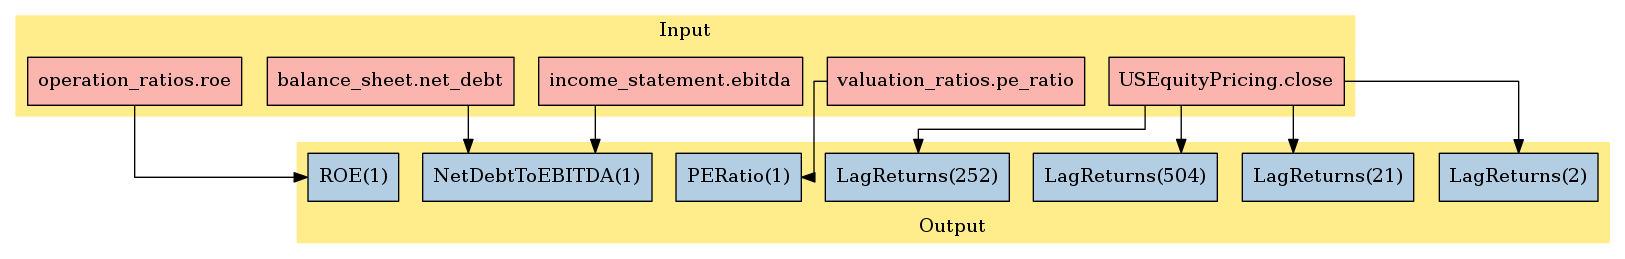

In [29]:
pipe.show_graph('png')

This function will allow us to run the pipeline.

In [30]:
from quantopian.research import run_pipeline

Now let's actually run it and check out our results.

In [31]:
# This takes a few minutes.
results = run_pipeline(pipe, start_date, end_date)
results

nd_to_ebitda        pe  \
2014-01-02 00:00:00+00:00 Equity(2 [AA])             41.630682   35.2113   
                          Equity(21 [AAME])           1.213764    9.0009   
                          Equity(24 [AAPL])           0.224915   13.9860   
                          Equity(25 [AA_PR])         41.630682       NaN   
                          Equity(31 [ABAX])           0.012321   42.9185   
                          Equity(39 [DDC])            6.061645   62.8931   
                          Equity(41 [ARCB])                NaN       NaN   
                          Equity(52 [ABM])            5.282158   21.4133   
                          Equity(53 [ABMD])                NaN  196.0784   
                          Equity(62 [ABT])            4.869725    9.0744   
                          Equity(64 [ABX])            9.946293   10.2987   
                          Equity(66 [AB])             2.027860   16.3934   
                          Equity(67 [ADSK])                NaN   41.6667   
                          Equity(69 [ACAT])           0.094535   18.5185   
                          Equity(70 [VBF])                 NaN       NaN   
                          Equity(76 [TAP])           13.618210   19.5695   
                          Equity(84 [ACET])           1.205697   20.7039   
                          Equity(86 [ACG])                 NaN       NaN   
                          Equity(88 [ACI])          -16.887137   14.7493   
                          Equity(99 [ACO])           -9.463415   44.4444   
                          Equity(100 [IEP])           3.087287   16.3666   
                          Equity(106 [ACU])           7.594486   12.1212   
                          Equity(110 [ACXM])          0.619904   49.7512   
                          Equity(112 [ACY])          23.485377    4.0193   
                          Equity(114 [ADBE])          3.567317  101.0101   
                          Equity(117 [AEY])           1.693403   15.5763   
                          Equity(122 [ADI])           1.515914   22.4719   
                          Equity(128 [ADM])           3.488953   21.4133   
                          Equity(134 [SXCL])               NaN       NaN   
                          Equity(149 [ADX])                NaN       NaN   
...                                                        ...       ...   
2015-01-02 00:00:00+00:00 Equity(48254 [WK])               NaN       NaN   
                          Equity(48255 [MPG])        15.905574   19.7916   
                          Equity(48256 [CNXR])      274.512195       NaN   
                          Equity(48257 [HDP])              NaN       NaN   
                          Equity(48258 [JRVR])        3.874194    9.5831   
                          Equity(48262 [TMUS_P])      9.185039       NaN   
                          Equity(48275 [MDVX_U])           NaN       NaN   
                          Equity(48290 [ONDK])      -69.310622       NaN   
                          Equity(48292 [RMP])              NaN       NaN   
                          Equity(48293 [BBP])              NaN       NaN   
                          Equity(48294 [BBC])              NaN       NaN   
                          Equity(48295 [IVAL])             NaN       NaN   
                          Equity(48304 [BLCM])             NaN       NaN   
                          Equity(48305 [DIVY])             NaN       NaN   
                          Equity(48317 [JUNO])             NaN       NaN   
                          Equity(48318 [ABEO_W])           NaN       NaN   
                          Equity(48320 [TRIL])             NaN       NaN   
                          Equity(48330 [DIAX])             NaN       NaN   
                          Equity(48331 [TANO])             NaN       NaN   
                          Equity(48332 [FCAM])             NaN       NaN   
                          Equity(48348 [EQAL])             NaN       NaN   
                      

Visually inspect the data before doing anything else. It's hard to see in the graph below, but the nd_to_ebitda values appear cut off starting in Februrary. Upon closer inspection, some values were infinity, so we'll handle that.


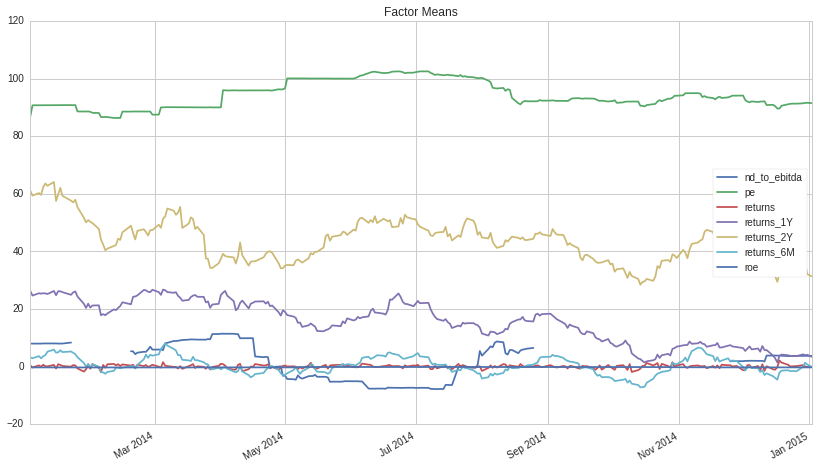

In [32]:
results.groupby(level=0).mean().plot();
plt.title('Factor Means');

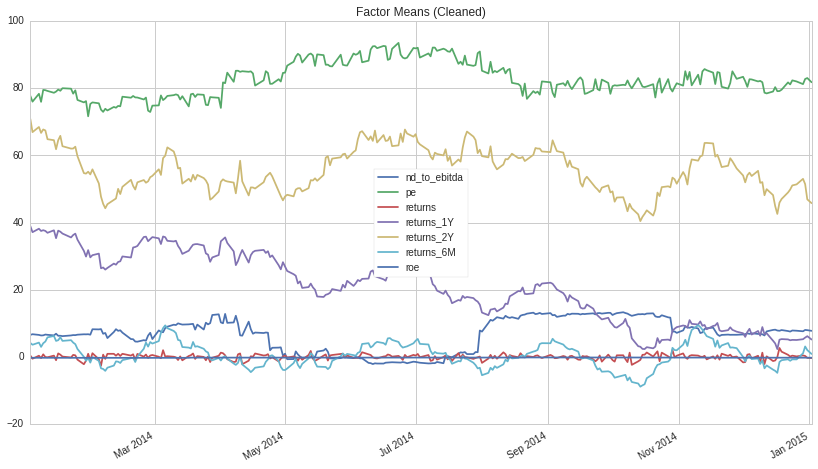

In [34]:
# filter out inf and drop NaNs
clean = results[np.isfinite(results)].dropna()
clean.groupby(level=0).mean().plot();
plt.title('Factor Means (Cleaned)');

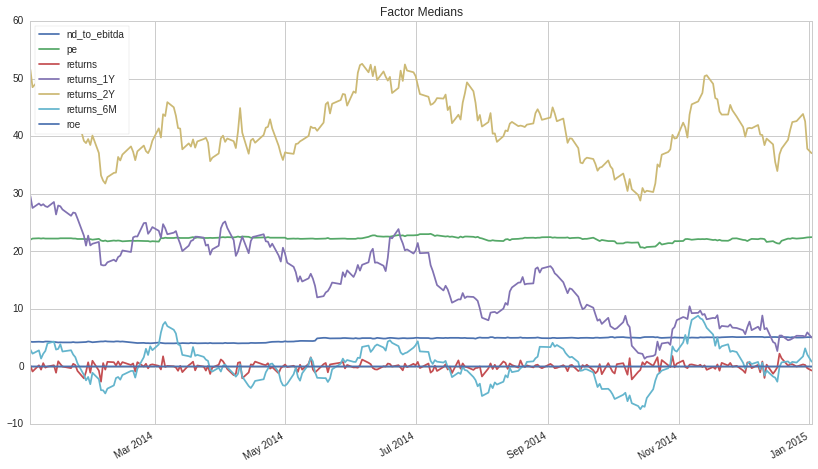

In [35]:
clean.groupby(level=0).median().plot();
plt.title('Factor Medians');

Let's compute the Z-scores for each factor at each time period and while we're at it, clean up any outliers using winsorization. First we do this for a single factor on a single date and inspect the results.

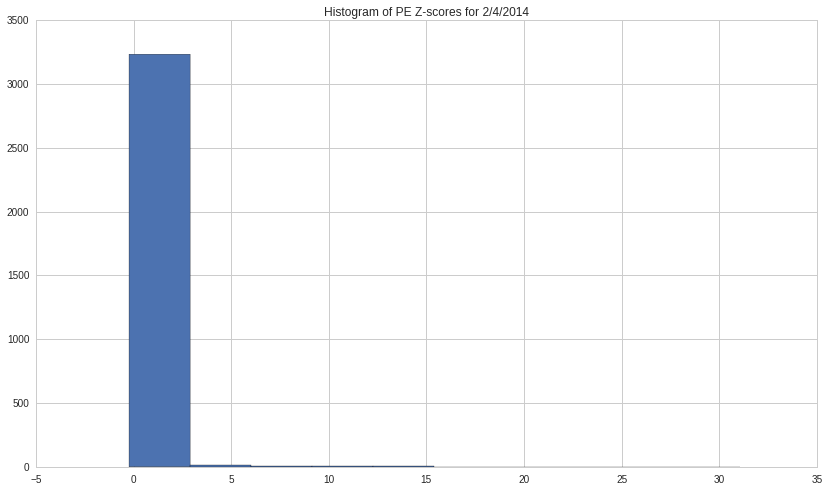

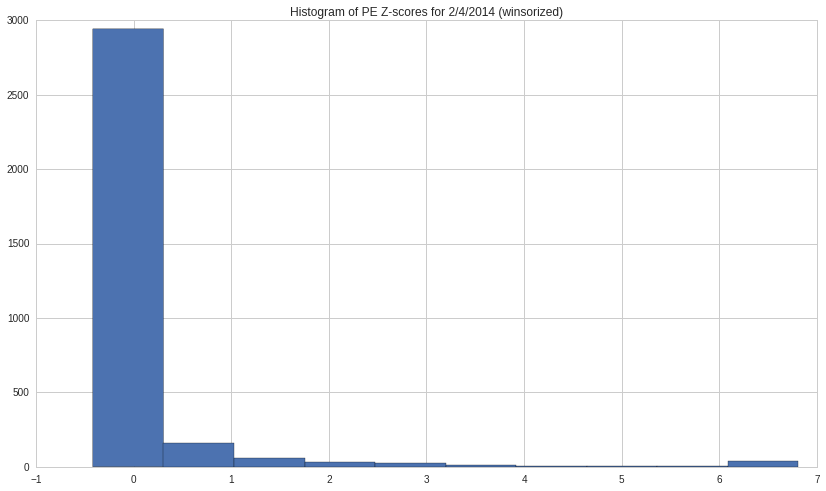

In [48]:
from scipy import stats

a = clean['pe'].loc['2014-02-04']
tmp = stats.zscore(a)
plt.figure()
plt.title('Histogram of PE Z-scores for 2/4/2014')
plt.hist(tmp);


scipy.stats.mstats.winsorize(x, inplace=True, limits=.01)
tmp = stats.zscore(x)
plt.figure()
plt.title('Histogram of PE Z-scores for 2/4/2014 (winsorized)')
plt.hist(tmp);

Looks OK. Let's get winsorized z-scores of the factor weights across universe of stocks for each time period. Make sure the mean is 0 and std is 1 for all the factors.

In [50]:
def getZScore(data):
    scipy.stats.mstats.winsorize(data, inplace=True, limits=.01)
    return scipy.stats.zscore(data)

transformed = clean.groupby(level=0).transform(getZScore)
transformed.describe()


,nd_to_ebitda,pe,returns,returns_1Y,returns_2Y,returns_6M,roe
count,8.239730e+05,8.239730e+05,8.239730e+05,8.239730e+05,8.239730e+05,8.239730e+05,8.239730e+05
mean,4.147304e-19,6.349229e-18,3.899180e-18,1.463952e-18,-2.543626e-18,-4.745551e-19,1.264739e-18
std,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00
min,-5.438181e+00,-4.239636e-01,-4.839998e+00,-2.525098e+00,-1.968202e+00,-3.840473e+00,-8.454239e+00
25%,-3.337062e-01,-3.165660e-01,-4.569862e-01,-5.329902e-01,-5.545204e-01,-4.867438e-01,5.984434e-02
50%,-1.884083e-01,-2.689669e-01,-9.952395e-03,-1.072711e-01,-1.540934e-01,1.971767e-03,1.335177e-01
75%,1.535995e-01,-1.530835e-01,4.450272e-01,3.800078e-01,3.392519e-01,4.795768e-01,2.005481e-01
max,6.818310e+00,7.535904e+00,4.705247e+00,5.136172e+00,4.992154e+00,4.715714e+00,2.734357e+00


It's time to get the factor returns for each time period. We do this using linear regression on the daily realized returns.

In [54]:
def getFactorReturns(data):
    daily_returns = data['returns']
    roe = data['roe']
    pe = data['pe']
    nd_to_ebitda = data['nd_to_ebitda']
    ret_6M = data['returns_6M']
    ret_1Y = data['returns_1Y']
    ret_2Y = data['returns_2Y']
    constant = pd.TimeSeries(np.ones(len(daily_returns.index)), index=daily_returns.index)
    df_day = pd.DataFrame({'R': daily_returns,
                           'roe': roe,
                           'pe': pe,
                           'nd_to_ebitda': nd_to_ebitda,
                           'ret_6M': ret_6M,
                           'ret_1Y': ret_1Y,
                           'ret_2Y': ret_2Y,
                           'Constant': constant})
    df_day = df_day.dropna()

    # Perform linear regression to get the coefficients in the model
    return regression.linear_model.OLS(df_day['R'], 
                                df_day[['roe', 'pe','nd_to_ebitda','ret_6M','ret_1Y','ret_2Y','Constant']]).fit().params


factor_returns = transformed.groupby(level=0).apply(getFactorReturns)


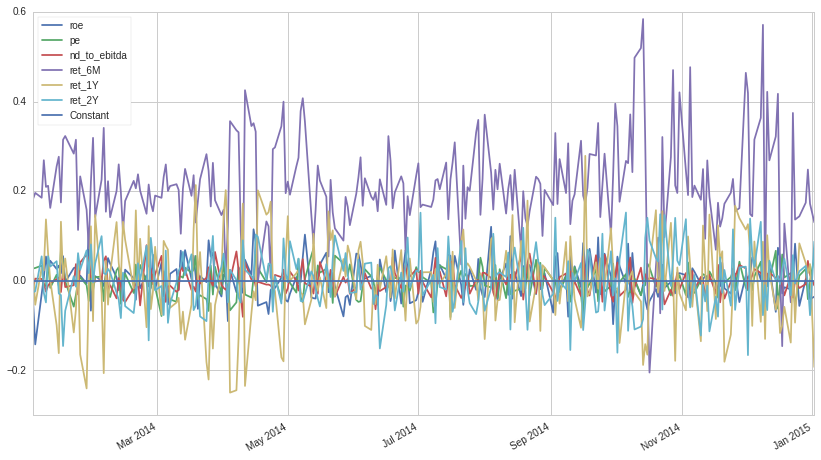

In [93]:
factor_returns.plot();

What jumps out is the 6M return factor returns which seems abnormally high. I guess it could mean that during this time period (2014-2015), the past 6M returns were highly correlated to daily returns. We need to look at the statistics of the linear regression and could eventually try a different time period or use 1M forward returns instead of daily, etc. More investigation is needed here, but let's move on to the next part.

# Regression against a sample portfolio

In this section we take the previously computed factor returns and regress against the returns of a sample portfolio. The goal is to see which, if any, of the factors have predictive power.

In [94]:
# Get returns data for our portfolio - I believe this fetches from Yahoo! Finance
portfolio = get_pricing(['MSFT', 'AAPL', 'YHOO', 'FB', 'TSLA'], 
                        fields='price', start_date=start_date, end_date=end_date).pct_change()[1:]
returns_tech_port = np.mean(portfolio, axis=1)

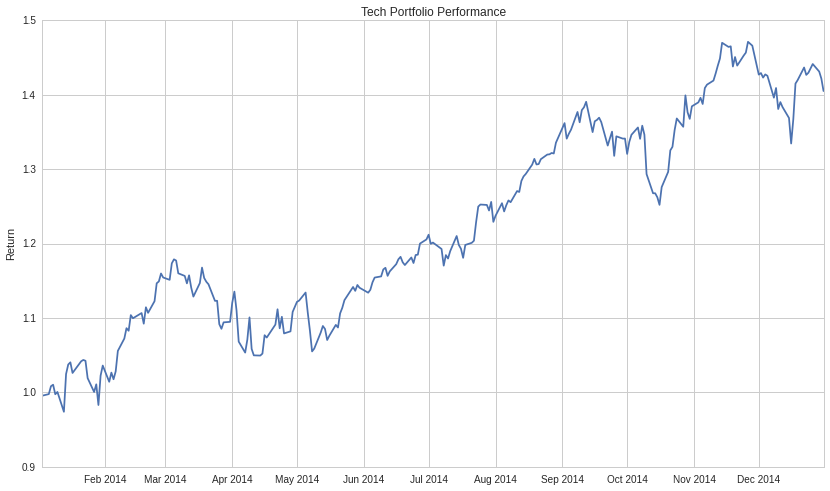

In [59]:
plt.title('Tech Portfolio Performance')
plt.ylabel('Return')
plt.plot(R.index, np.cumprod(returns_tech_port.values+1, axis=0));

In [76]:
# Define a constant to compute intercept
constant = pd.TimeSeries(np.ones(len(returns_tech_port.index)), index=returns_tech_port.index)

df = pd.DataFrame({'R_port': returns_tech_port,
                       'roe': factor_returns['roe'],
                       'pe': factor_returns['pe'],
                       'nd_to_ebitda': factor_returns['nd_to_ebitda'],
                       'ret_6M': factor_returns['ret_6M'],
                       'ret_1Y': factor_returns['ret_1Y'],
                       'ret_2Y': factor_returns['ret_2Y'],
                       'Constant': constant})
df = df.dropna()

In [92]:
# Perform linear regression to get the coefficients in the model
fit = regression.linear_model.OLS(df['R_port'], df[['roe', 'pe', 'nd_to_ebitda',
                                                          'ret_6M', 'ret_1Y', 'ret_2Y']]).fit()

#fit.params
b1, b2, b3, b4, b5, b6 = fit.params
# Print the coefficients from the linear regression
print ('Historical Sensitivities of portfolio returns to factors:\nROE: %f\nPE: %f\nDebt/Ebitda:' +
'%f\n6M returns %f\n1Y returns %f\n2Y returns %f') %  (b1, b2, b3, b4, b5, b6)

Historical Sensitivities of portfolio returns to factors:
ROE: 0.035454
PE: 0.022036
Debt/Ebitda:0.000731
6M returns 0.000369
1Y returns 0.013053
2Y returns -0.017917


In [84]:
fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 R_port   R-squared:                       0.027
Model:                            OLS   Adj. R-squared:                  0.003
Method:                 Least Squares   F-statistic:                     1.131
Date:                Fri, 08 Apr 2016   Prob (F-statistic):              0.345
Time:                        03:31:23   Log-Likelihood:                 723.65
No. Observations:                 251   AIC:                            -1435.
Df Residuals:                     245   BIC:                            -1414.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [95.0% Conf. Int.]
--------------------------------------------------------------------------------
roe              0.0355      0.022      1.586      0.114        -0.009     0.079
pe               0.0220      0.032      0.694      0.488        -0.041     0.085
nd_to_ebitda     0.0007      0.034      0.021      0.983        -0.067     0.068
ret_6M           0.0004      0.004      0.100      0.921        -0.007     0.008
ret_1Y           0.0131      0.010      1.323      0.187        -0.006     0.032
ret_2Y          -0.0179      0.015     -1.234      0.218        -0.047     0.011
==============================================================================
Omnibus:                        7.812   Durbin-Watson:                   2.018
Prob(Omnibus):                  0.020   Jarque-Bera (JB):               12.108
Skew:                          -0.148   Prob(JB):                      0.00235
Kurtosis:                       4.034   Cond. No.                         10.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

The results say we have absoluetly ZERO predicitve power, but let's take a look at the rolling beta values anyway.

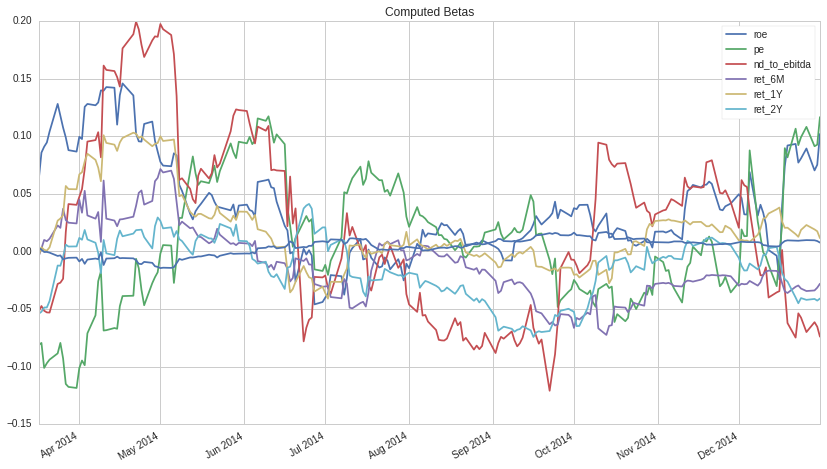

In [86]:
# Perform linear regression to get the coefficients in the model
model = pd.stats.ols.MovingOLS(y = df['R_port'], x = df[['roe', 'pe', 'nd_to_ebitda',
                                                          'ret_6M', 'ret_1Y', 'ret_2Y']],
                              window_type='rolling',
                              window=50)
#model = pd.stats.ols.MovingOLS(y = df['R'], x=df[['M', 'SMB', 'HML']], 
#                             window_type='rolling', 
#                             window=100)
rolling_parameter_estimates = model.beta
rolling_parameter_estimates.plot();
plt.title('Computed Betas');
plt.legend(['roe', 'pe', 'nd_to_ebitda','ret_6M', 'ret_1Y', 'ret_2Y']);

What a mess! The coefficients are varying a lot each day, so it's obviously time to start live trading with this model.